# Explore Nextclade Mutations

In this notebook we explore enrichment in the input and output mutations to the model

# Init

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import pickle
import scipy.stats as stats

In [2]:
plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100

## Functions

In [3]:
def preprocess_nextclade_counts(nextclade_counts_df):
    # convert index to columns and split, extract aa changes
    idx = nextclade_counts_df.index
    nextclade_counts_df[['protein','aa_change']] = nextclade_counts_df.index.to_frame()[0].str.split(':',expand=True)
    nextclade_counts_df["aa_from"] = nextclade_counts_df['aa_change'].astype(str).str[0]
    nextclade_counts_df["aa_to"] = nextclade_counts_df['aa_change'].astype(str).str[-1]
    nextclade_counts_df["aa_change"] = nextclade_counts_df["aa_from"] + '_' + nextclade_counts_df["aa_to"]
    nextclade_counts_df = nextclade_counts_df.rename(columns={0:'count'})
    
    return nextclade_counts_df

In [4]:
def preprocess_mutations(mutations_tsv):
    mutations_tsv[['gene','aa_change']] = mutations_tsv['mutation'].str.split(':',expand=True)
    mutations_tsv['aa_from'] = mutations_tsv['aa_change'].str[0:1]
    mutations_tsv['aa_to'] = mutations_tsv['aa_change'].str[-1]
    mutations_tsv['aa_position'] = mutations_tsv['aa_change'].str[1:-1]
    return mutations_tsv

In [5]:
def get_event_frequencies(mutations_proc):
    mutations_1 = mutations_proc[['aa_from','aa_to']].copy()
    mutations_1['count'] = 1
    mutations_1 = mutations_1.groupby(['aa_from','aa_to']).aggregate({'count':'sum'})
    mutations_1 = mutations_1.reset_index()
    pre_pivot = mutations_1.copy()
    mutations_1 = mutations_1.pivot(index='aa_from',columns='aa_to',values='count')
    cols = mutations_1.columns
    rows = mutations_1.index
    
    mutations_1 = mutations_1.values
    mutations_1 = np.nan_to_num(mutations_1, 0)
    
    return {
        'vals': mutations_1,
        'cols': cols,
        'rows': rows,     
        'prepivot': pre_pivot,
    }

In [6]:
def score_mutations(test_data, background_data, exclude_mutations = set(('*')), verbose=True):
    # from
    test_mutations_from = set(test_data['aa_from'].unique())
    bg_mutations_from = set(background_data['aa_from'].unique())
    common_mutations_from = test_mutations_from.intersection(bg_mutations_from)
    used_mutations_from = common_mutations_from - exclude_mutations
    
    # to
    test_mutations_to = set(test_data['aa_to'].unique())
    bg_mutations_to = set(background_data['aa_to'].unique())
    common_mutations_to = test_mutations_to.intersection(bg_mutations_to)
    used_mutations_to = common_mutations_to - exclude_mutations
    
    # subset
    test_data_subset = test_data[
        (test_data['aa_from'].isin(used_mutations_from)) & 
        (test_data['aa_to'].isin(used_mutations_to))
    ]
    bg_data_subset = background_data[
        (background_data['aa_from'].isin(used_mutations_from)) &
        (background_data['aa_to'].isin(used_mutations_to))
    ]
    
    test_sum = test_data_subset['count'].sum()
    bg_sum = bg_data_subset['count'].sum()
    
    # n_tests ignores the diagonal
    n_tests = ((len(used_mutations_from) * len(used_mutations_to)) - max(len(used_mutations_from), len(used_mutations_to)))

    alpha = 0.05
    threshold = alpha / n_tests
    
    ret = {'from': [], 'to': [], 'pval': [], 'qval': [], 'obs': [], 'exp': [], 'significant': []}
    
    # Calculate background 
    for from_mut in used_mutations_from:
        for to_mut in used_mutations_to:
            obs_count = test_data_subset.loc[
                (test_data_subset['aa_from'] == from_mut) &
                (test_data_subset['aa_to'] == to_mut)
            ]['count'].values
            if len(obs_count) ==1:
                obs_count = obs_count[0]
            else:
                obs_count = 0
                
            bg_count = bg_data_subset.loc[
                (bg_data_subset['aa_from'] == from_mut) &
                (bg_data_subset['aa_to'] == to_mut)
            ]['count'].values
            if len(bg_count) == 1:
                bg_count = bg_count[0]
            else:
                bg_count = 0
            
            bg_prob = bg_count / bg_sum
            
            pval = stats.binom_test(obs_count, test_sum, bg_prob, alternative='greater')
            sign = pval < threshold
            
            qval = min(1, pval * n_tests)
             
            if (verbose):
                print(f"{from_mut} -> {to_mut}, obs: {obs_count}/{test_sum} bg_prob: {bg_prob}, pval: {pval}")
    
            ret['from'].append(from_mut)
            ret['to'].append(to_mut)
            ret['obs'].append(obs_count)
            ret['exp'].append((bg_prob * test_sum))
            ret['pval'].append(pval)
            ret['qval'].append(qval)
            ret['significant'].append(sign)
            
    results = pd.DataFrame(ret)
    
    results = results.sort_values('pval')
    
    return results

In [7]:
def get_top55_spike(mutations_proc):
    return mutations_proc[mutations_proc['gene'] == 'S'].sort_values('Δ log R', ascending=False).head(55)

# Load and prepare data

## Nextclade counts

In [8]:
# load nextclade counts
with open("results/nextclade.counts.pkl", 'rb') as f:
    nextclade_counts = pickle.load(f)

In [9]:
# get data frame form index
nextclade_counts_df_1 = pd.DataFrame.from_dict(nextclade_counts, orient='index')

In [10]:
nextclade_counts_df = preprocess_nextclade_counts(nextclade_counts_df_1)

In [11]:
# Generate a version with all counts set to 1 so that we can just look at frequency of types of mutations
nextclade_counts_no_freq = nextclade_counts_df.copy()
nextclade_counts_no_freq['count'] = 1

In [12]:
# Get total summed counts
summarized_counts = nextclade_counts_df.groupby(['aa_from','aa_to']).agg({'count':'sum'})

In [13]:
summarized_counts_1 = summarized_counts['count']
summarized_counts_1 = summarized_counts_1.reset_index()
nextclade_comparison_table = summarized_counts_1.copy()

In [14]:
aa_changes = summarized_counts_1.pivot(index='aa_from',columns='aa_to',values='count')
aa_changes_np = aa_changes.to_numpy()
aa_changes_np = np.nan_to_num(aa_changes_np, nan=0.0)

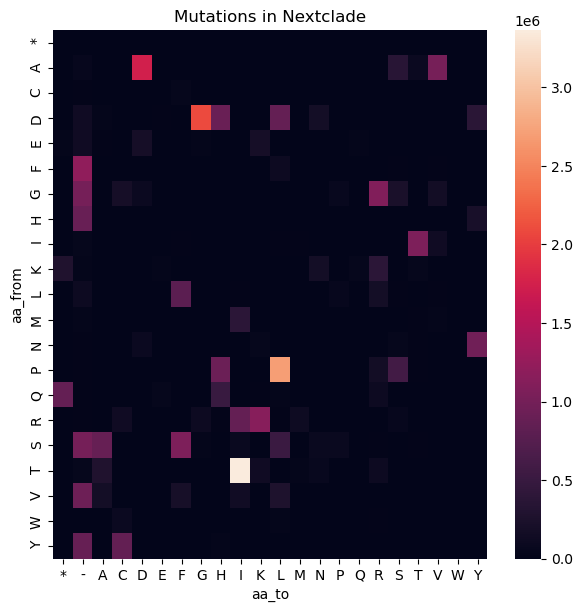

In [15]:
# Generate Heatmap
fig = sns.heatmap(aa_changes_np,
            xticklabels=aa_changes.columns,
            yticklabels=aa_changes.index,)
fig.set(xlabel='aa_to',ylabel='aa_from',title='Mutations in Nextclade')
plt.pyplot.savefig('paper/mutation_scoring/nextclade.png')

## Input to model (mutations.tsv)

In [16]:
mutations_tsv = pd.read_table('paper/mutations.tsv')
mutations_proc = preprocess_mutations(mutations_tsv)
mutations_freq = get_event_frequencies(mutations_proc)

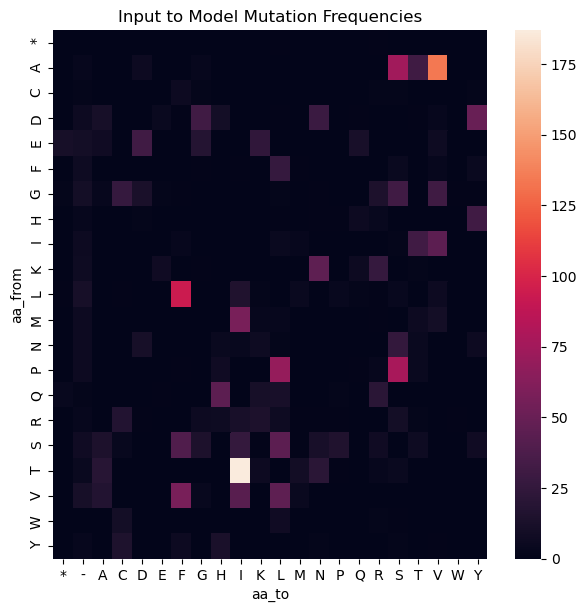

In [17]:
# heatmap
fig = sns.heatmap(mutations_freq['vals'],
            xticklabels=mutations_freq['cols'],
            yticklabels=mutations_freq['rows'],)
fig.set(xlabel='aa_to',ylabel='aa_from',
        title='Input to Model Mutation Frequencies')
plt.pyplot.savefig('paper/mutation_scoring/input_to_model.png')

## Top 255 global amino acids

In [18]:
top255_global = mutations_proc.sort_values('Δ log R',ascending =False).head(255)
top255_freq = get_event_frequencies(top255_global)

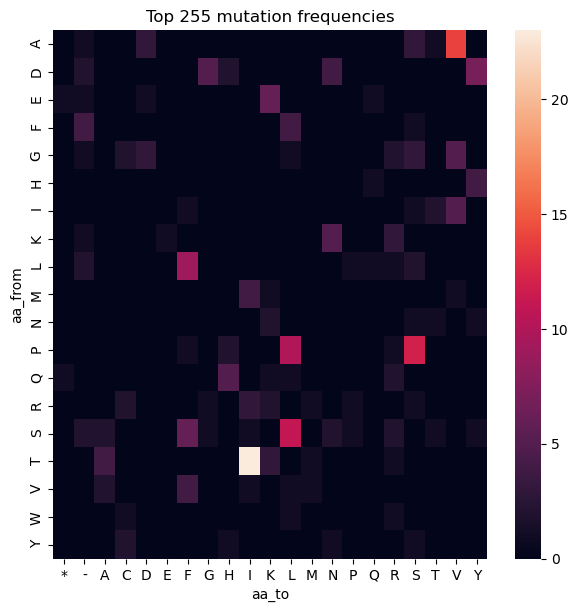

In [19]:
# heatmap
fig = sns.heatmap(top255_freq['vals'],
            xticklabels=top255_freq['cols'],
            yticklabels=top255_freq['rows'],)
fig.set(xlabel='aa_to',ylabel='aa_from',
        title='Top 255 mutation frequencies')
plt.pyplot.savefig('paper/mutation_scoring/top_255_global.png')

## Top 55 Spike Vs Features (mutations.tsv)

In [20]:
top55_spike = mutations_proc.loc[mutations_proc['gene'] == 'S'].sort_values('Δ log R',ascending =False).head(55)
top55_spike_freq = get_event_frequencies(top55_spike)

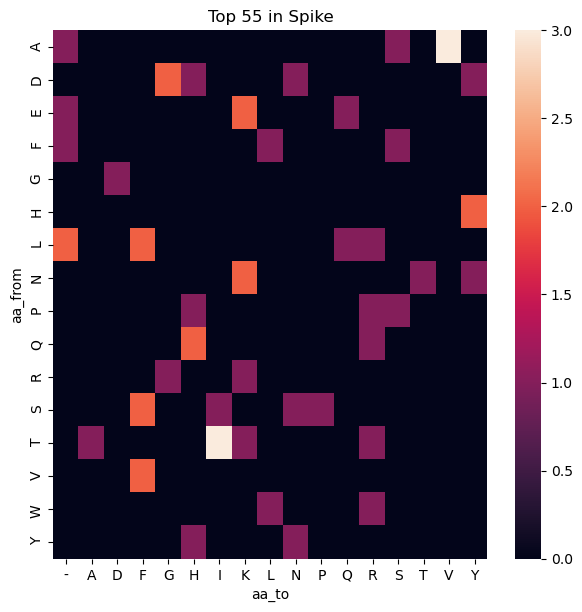

In [21]:
# heatmap
fig = sns.heatmap(top55_spike_freq['vals'],
            xticklabels=top55_spike_freq['cols'],
            yticklabels=top55_spike_freq['rows'],)
fig.set(xlabel='aa_to',ylabel='aa_from',
        title='Top 55 in Spike')
plt.pyplot.savefig('paper/mutation_scoring/top_55_spike.png')

# Score sets of mutations

## Input to model vs Nextclade

In [22]:
mutations_tsv_vs_nextclade = score_mutations(mutations_freq['prepivot'], nextclade_comparison_table, verbose = False)
mutations_tsv_vs_nextclade.to_csv('paper/mutation_scoring/input_vs_nextclade.csv')

## Top 255 Vs Input to Model

In [23]:
top255_vs_mutation_tsv = score_mutations(top255_freq['prepivot'], mutations_freq['prepivot'], verbose=False)
top255_vs_mutation_tsv.to_csv('paper/mutation_scoring/top255_VS_input.csv')

## Top 55 VS Input to Model

In [24]:
top55_spike_VS_mutations_tsv = score_mutations(top55_spike_freq['prepivot'], mutations_freq['prepivot'], verbose = False)
top55_spike_VS_mutations_tsv.to_csv('paper/mutation_scoring/top55_VS_input.csv')

## Top 55 VS nextclade

In [25]:
top55_spike_VS_nextclade = score_mutations(top55_spike_freq['prepivot'], nextclade_comparison_table, verbose = False)
top55_spike_VS_nextclade.to_csv('paper/mutation_scoring/top55_VS_nextclade.csv')

## Input to Model vs Nextclade

In [26]:
mutations_tsv_VS_nextclade = score_mutations(top55_spike_freq['prepivot'], nextclade_comparison_table, verbose = False)
mutations_tsv_VS_nextclade.to_csv('paper/mutation_scoring/input_VS_nextclade.csv')

# Combine results into table

In [27]:
mutations_tsv_vs_nextclade = mutations_tsv_vs_nextclade.set_index(['from','to'])
top255_vs_mutation_tsv = top255_vs_mutation_tsv.set_index(['from','to'])
top55_spike_VS_mutations_tsv = top55_spike_VS_mutations_tsv.set_index(['from','to'])
top55_spike_VS_nextclade = top55_spike_VS_nextclade.set_index(['from','to'])
mutations_tsv_VS_nextclade = mutations_tsv_VS_nextclade.set_index(['from','to'])

In [28]:
mutations_tsv_vs_nextclade_premerge = mutations_tsv_vs_nextclade[['qval']]
mutations_tsv_vs_nextclade_premerge.columns = ['qval_input_vs_nextclade']

top255_vs_mutation_tsv_premerge = top255_vs_mutation_tsv[['qval']]
top255_vs_mutation_tsv_premerge.columns = ['qval_top255_vs_input']

top55_spike_VS_mutations_tsv_premerge = top55_spike_VS_mutations_tsv[['qval']]
top55_spike_VS_mutations_tsv_premerge.columns = ['qval_top55_spike_vs_input']

top55_spike_VS_nextclade_premerge = top55_spike_VS_nextclade[['qval']]
top55_spike_VS_nextclade_premerge.columns = ['qval_top55_vs_nextclade']

mutations_tsv_VS_nextclade_premerge = mutations_tsv_VS_nextclade[['qval']]
mutations_tsv_VS_nextclade_premerge.columns = ['qval_mutations_tsv_VS_nextclade']

In [29]:
aggregated_qvals = mutations_tsv_vs_nextclade_premerge.merge(
    top255_vs_mutation_tsv_premerge,left_index=True, right_index=True).merge(
    top55_spike_VS_mutations_tsv_premerge, left_index=True, right_index=True).merge(
    top55_spike_VS_nextclade_premerge, left_index=True, right_index=True).merge(
    mutations_tsv_VS_nextclade_premerge, left_index=True, right_index=True).reset_index()

In [30]:
aggregated_qvals.to_csv('paper/mutation_scoring/aggregated_qvalues.csv')